In [1]:
import torch.nn as nn
from GRU_pipeline import DataHolder, paths, dicDataset, GRUModel, pad_collate, HierarchicalDataset, Pipeline

DH = DataHolder(**paths)
#HD = HierarchicalDataset(DH)
#dl = HD.dataloader()

In [2]:
output = DH.make_train_test_datasets(test_size = .15, val_size = .17)
class_weights = output['class_weights']
openface_1  = output['datasets']['openface_1']
openface_2  = output['datasets']['openface_2']
opensmile_1 = output['datasets']['opensmile_1']
opensmile_2 = output['datasets']['opensmile_2']

Training on cpu
loss epoch 30: 1.966097
loss epoch 60: 1.922216
loss epoch 90: 1.906189
loss epoch 120: 1.899251
Early stop activated, stopped at epoch 122


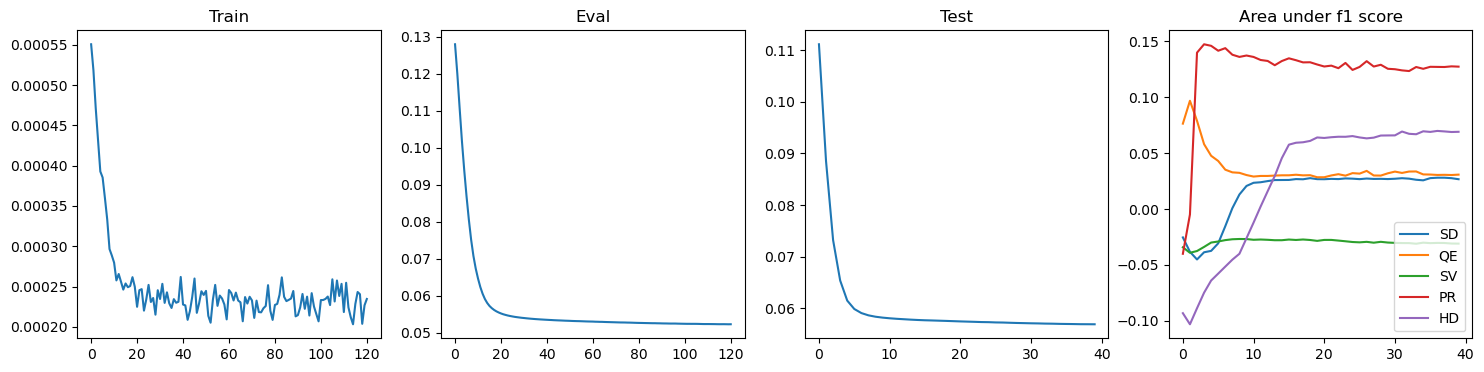

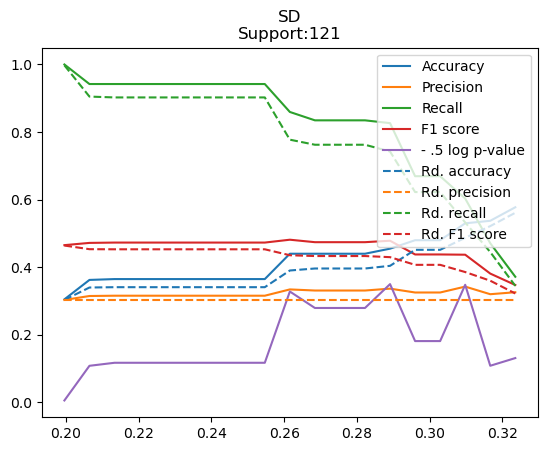

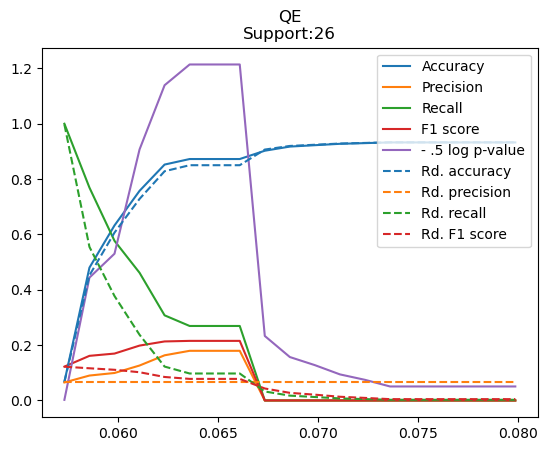

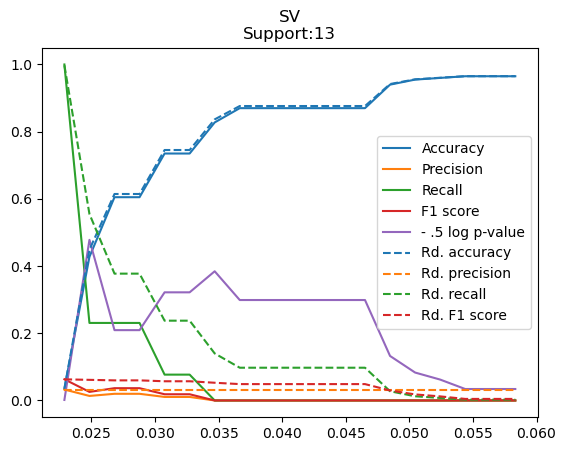

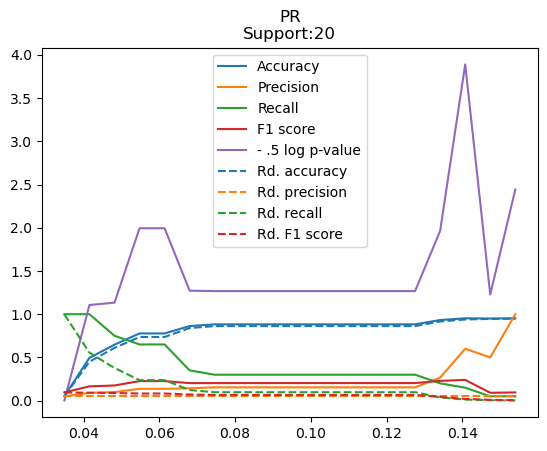

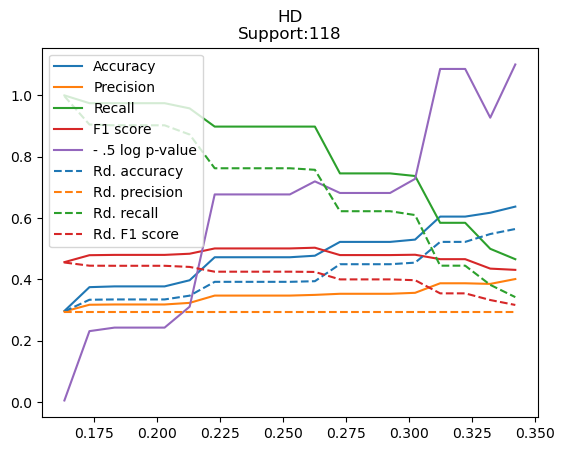

[0.02819177460051999,
 0.03142883862217137,
 -0.030461615543850396,
 0.12596680755129022,
 0.06985466908460068]

In [8]:
model_args = {
    'input_dim':17,
    'hidden_dim':8,
    'layer_dim':3,
    'output_dim':5,
    'dropout_prob':.0
}

args={
    'model': GRUModel(**model_args),
    'features_1':openface_1,
    'features_2':openface_2,
    #'features_1':opensmile_1,
    #'features_2':opensmile_2,
    'criterion':nn.MSELoss()
    #'criterion':nn.KLDivLoss(reduction='batchmean')
}
pipe = Pipeline(**args)
pipe.train(epoch=150,lr=1e-3, early_stop=True)
pipe.plot_losses()
pipe.eval_model(plot=True)

In [13]:
import pandas as pd
report = pd.DataFrame(pipe.hist_auf1c, columns=pipe.cats)
report['test'] = pipe.hist_test_loss
args

{'model': GRUModel(
   (gru): GRU(17, 8, num_layers=3, batch_first=True)
   (fc): Linear(in_features=8, out_features=5, bias=True)
   (s): Sigmoid()
 ),
 'features_1': <GRU_pipeline.dicDataset at 0x10fa3fb20>,
 'features_2': <GRU_pipeline.dicDataset at 0x10fa3ffa0>,
 'criterion': MSELoss()}